<a href="https://colab.research.google.com/github/Sebastianrix/Data-Things/blob/main/MiniProject_Pet_segmentation__RE_RUN_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))


Torch: 2.9.0+cu126
CUDA available: True
GPU: Tesla T4


In [ ]:
import sys
!"{sys.executable}" -m pip install -q albumentations opencv-python scikit-image matplotlib tqdm pillow boto3
print("Extra libs ready")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 136.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.1 MB/s eta 0:00:00
Extra libs ready


In [ ]:
import torch

class Cfg:
    img_size    = 256
    batch_size  = 12
    num_workers = 0
    lr          = 2e-4
    betas       = (0.5, 0.999)
    epochs      = 300
    lambda_l1   = 100.0
    lambda_dice = 1.0
    lambda_cls  = 1.0

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE


'cuda'

In [ ]:
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import torch

class PetsSegCLSDataset(Dataset):
    def __init__(self, root="./data", split="trainval", img_size=256):
        self.ds = OxfordIIITPet(
            root=root,
            split=split,
            download=True,
            target_types=("segmentation", "category")
        )

        self.tf_img = transforms.Compose([
            transforms.Resize((img_size, img_size), interpolation=Image.BILINEAR),
            transforms.ToTensor(),
        ])

        self.tf_mask = transforms.Resize(
            (img_size, img_size),
            interpolation=Image.NEAREST
        )

    def __len__(self):
        return len(self.ds)

    def __getitem__(self, idx):
        img, (seg, label) = self.ds[idx]
        img_t = self.tf_img(img)
        seg_np = np.array(self.tf_mask(seg), dtype=np.uint8)


        mask = np.isin(seg_np, [1, 2]).astype(np.float32)


        mask_t = torch.from_numpy(mask)[None, ...]

        return img_t, mask_t, torch.tensor(label, dtype=torch.long)


In [ ]:
ds = PetsSegCLSDataset(img_size=Cfg.img_size)
print("Dataset length:", len(ds))


100%|██████████| 792M/792M [00:32<00:00, 24.4MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 12.6MB/s]


Dataset length: 3680


In [ ]:
from torch.utils.data import DataLoader
import random

n = len(ds); val_n = int(0.1 * n)
idx = list(range(n)); random.shuffle(idx)
val_idx = set(idx[:val_n])
train_idx = [i for i in range(n) if i not in val_idx]

class Subset(Dataset):
    def __init__(self, base, ids):
        self.base, self.ids = base, ids
    def __len__(self):
        return len(self.ids)
    def __getitem__(self, i):
        return self.base[self.ids[i]]

dl_train = DataLoader(Subset(ds, train_idx), batch_size=Cfg.batch_size,
                      shuffle=True, num_workers=Cfg.num_workers, pin_memory=True)
dl_val   = DataLoader(Subset(ds, list(val_idx)), batch_size=Cfg.batch_size,
                      shuffle=False, num_workers=Cfg.num_workers, pin_memory=True)

len(dl_train), len(dl_val)


(276, 31)

In [ ]:

ds_test = PetsSegCLSDataset(split="test", img_size=Cfg.img_size)
dl_test = DataLoader(ds_test,
                     batch_size=Cfg.batch_size,
                     shuffle=False,
                     num_workers=Cfg.num_workers,
                     pin_memory=True)

print("Train/Val size:", len(ds), " Test size:", len(ds_test))
print("Train batches:", len(dl_train), " Val batches:", len(dl_val), " Test batches:", len(dl_test))


Train/Val size: 3680  Test size: 3669
Train batches: 276  Val batches: 31  Test batches: 306


In [ ]:
x, m, y = ds[0]
print("Image:", x.shape, "Mask:", m.shape, "Label:", int(y))
m.min().item(), m.max().item()


Image: torch.Size([3, 256, 256]) Mask: torch.Size([1, 256, 256]) Label: 0


(0.0, 1.0)

In [ ]:
import torch.nn as nn
import torch

def enc_block(in_c, out_c, norm=True):
    layers = [nn.Conv2d(in_c, out_c, 4, 2, 1, bias=not norm)]
    if norm: layers += [nn.BatchNorm2d(out_c)]
    layers += [nn.LeakyReLU(0.2, inplace=True)]
    return nn.Sequential(*layers)

def dec_block(in_c, out_c, dropout=False):
    layers = [nn.ConvTranspose2d(in_c, out_c, 4, 2, 1, bias=False),
              nn.BatchNorm2d(out_c), nn.ReLU(inplace=True)]
    if dropout: layers += [nn.Dropout(0.5)]
    return nn.Sequential(*layers)

class UNetGenerator(nn.Module):
    def __init__(self, n_classes=37, in_c=3, base=64):
        super().__init__()
        # Encoder
        self.e1 = enc_block(in_c, base, norm=False)
        self.e2 = enc_block(base, base*2)
        self.e3 = enc_block(base*2, base*4)
        self.e4 = enc_block(base*4, base*8)
        self.e5 = enc_block(base*8, base*8)
        self.e6 = enc_block(base*8, base*8)
        self.e7 = enc_block(base*8, base*8)
        self.e8 = enc_block(base*8, base*8)
        # Decoder (skip connections)
        self.d1 = dec_block(base*8, base*8, dropout=True)
        self.d2 = dec_block(base*16, base*8, dropout=True)
        self.d3 = dec_block(base*16, base*8, dropout=True)
        self.d4 = dec_block(base*16, base*8)
        self.d5 = dec_block(base*16, base*4)
        self.d6 = dec_block(base*8, base*2)
        self.d7 = dec_block(base*4, base)
        self.d8 = nn.ConvTranspose2d(base*2, 1, 4, 2, 1)  # final mask logits
        # Classification head (from bottleneck)
        self.cls = nn.Sequential(
            nn.AdaptiveAvgPool2d(1), nn.Flatten(),
            nn.Linear(base*8, 256), nn.ReLU(True),
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        e1=self.e1(x); e2=self.e2(e1); e3=self.e3(e2); e4=self.e4(e3)
        e5=self.e5(e4); e6=self.e6(e5); e7=self.e7(e6); e8=self.e8(e7)
        d1=self.d1(e8)
        d2=self.d2(torch.cat([d1,e7],1))
        d3=self.d3(torch.cat([d2,e6],1))
        d4=self.d4(torch.cat([d3,e5],1))
        d5=self.d5(torch.cat([d4,e4],1))
        d6=self.d6(torch.cat([d5,e3],1))
        d7=self.d7(torch.cat([d6,e2],1))
        out=self.d8(torch.cat([d7,e1],1))
        cls=self.cls(e8)
        return out, cls

class PatchDiscriminator(nn.Module):
    def __init__(self, in_c=3+1, base=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_c, base, 4, 2, 1), nn.LeakyReLU(0.2, True),
            nn.Conv2d(base, base*2, 4, 2, 1, bias=False), nn.BatchNorm2d(base*2), nn.LeakyReLU(0.2, True),
            nn.Conv2d(base*2, base*4, 4, 2, 1, bias=False), nn.BatchNorm2d(base*4), nn.LeakyReLU(0.2, True),
            nn.Conv2d(base*4, base*8, 4, 1, 1, bias=False), nn.BatchNorm2d(base*8), nn.LeakyReLU(0.2, True),
            nn.Conv2d(base*8, 1, 4, 1, 1)
        )
    def forward(self, x):
        return self.net(x)

G = UNetGenerator(n_classes=37).to(DEVICE)
D = PatchDiscriminator().to(DEVICE)
opt_G = torch.optim.Adam(G.parameters(), lr=Cfg.lr, betas=Cfg.betas)
opt_D = torch.optim.Adam(D.parameters(), lr=Cfg.lr, betas=Cfg.betas)


In [ ]:
import torch.nn.functional as F
import torch

def gan_loss(pred, is_real):
    target = torch.ones_like(pred) if is_real else torch.zeros_like(pred)
    return F.binary_cross_entropy_with_logits(pred, target)

def dice_loss(logits, target, eps=1e-6):
    p = torch.sigmoid(logits)
    num = 2*(p*target).sum((1,2,3))
    den = (p*p + target*target).sum((1,2,3)) + eps
    return (1 - num/den).mean()

def iou_score(logits, target, thr=0.5, eps=1e-6):
    p = (torch.sigmoid(logits) > thr).float()
    inter = (p*target).sum((1,2,3))
    union = (p + target - p*target).sum((1,2,3)) + eps
    return (inter/union).mean().item()

def set_requires_grad(m, flag):
    for p in m.parameters(): p.requires_grad = flag


In [ ]:
from tqdm import tqdm

def train_one_epoch():
    G.train(); D.train()
    logs = {"G":0.0,"D":0.0,"IOU":0.0}

    for img, mask, ycls in tqdm(dl_train, ncols=100):
        img, mask, ycls = img.to(DEVICE), mask.to(DEVICE), ycls.to(DEVICE)


        set_requires_grad(D, True); opt_D.zero_grad()
        with torch.no_grad():
            fake_logits, _ = G(img)
            fake_prob = torch.sigmoid(fake_logits)
        real_pair = torch.cat([img, mask], 1)
        fake_pair = torch.cat([img, fake_prob], 1)
        loss_D = gan_loss(D(real_pair), True) + gan_loss(D(fake_pair.detach()), False)
        loss_D.backward(); opt_D.step()

        set_requires_grad(D, False); opt_G.zero_grad()
        fake_logits, cls_logits = G(img)
        fake_prob = torch.sigmoid(fake_logits)
        fake_pair = torch.cat([img, fake_prob], 1)

        loss_adv  = gan_loss(D(fake_pair), True)
        loss_l1   = F.l1_loss(fake_logits, mask)
        loss_dice = dice_loss(fake_logits, mask)
        loss_cls  = F.cross_entropy(cls_logits, ycls)
        loss_G = loss_adv + Cfg.lambda_l1*loss_l1 + Cfg.lambda_dice*loss_dice + Cfg.lambda_cls*loss_cls
        loss_G.backward(); opt_G.step()

        logs["G"]  += loss_G.item()
        logs["D"]  += loss_D.item()
        logs["IOU"]+= iou_score(fake_logits.detach(), mask)

    n = len(dl_train)
    return {k:v/n for k,v in logs.items()}

@torch.no_grad()
def evaluate():
    G.eval()
    iou, correct, total = 0.0, 0, 0
    for img, mask, y in dl_val:
        img, mask, y = img.to(DEVICE), mask.to(DEVICE), y.to(DEVICE)
        mlogits, clogits = G(img)
        iou += iou_score(mlogits, mask)
        pred = clogits.argmax(1)
        correct += (pred==y).sum().item()
        total   += y.numel()
    return {"IOU": iou/len(dl_val), "ACC": correct/total}


In [ ]:
def evaluate_test():
    G.eval()
    total_iou = 0.0
    correct   = 0
    total     = 0

    with torch.no_grad():
        for x, m, y in dl_test:
            x = x.to(DEVICE)
            m = m.to(DEVICE)
            y = y.to(DEVICE)

            mlogits, clogits = G(x)

            prob = torch.sigmoid(mlogits)
            pred_mask = (prob > 0.5).float()

            inter = (pred_mask * m).sum(dim=(1,2,3))
            union = ((pred_mask + m) > 0).float().sum(dim=(1,2,3)) + 1e-7
            batch_iou = (inter / union).mean().item()
            total_iou += batch_iou

            pred_cls = clogits.argmax(1)
            correct += (pred_cls == y).sum().item()
            total   += y.numel()

    return {
        "IOU": total_iou / len(dl_test),
        "ACC": correct / total
    }


In [ ]:
Cfg.epochs = 20


In [ ]:
history = {
    "train_G": [],
    "train_D": [],
    "train_IOU": [],
    "val_IOU": [],
    "val_ACC": []
}


In [ ]:
history = {
    "train_G": [],
    "train_D": [],
    "train_IOU": [],
    "val_IOU": [],
    "val_ACC": []
}



In [ ]:
best_iou = 0.0

for epoch in range(1, Cfg.epochs + 1):
    tr  = train_one_epoch()
    val = evaluate()

    history["train_G"].append(tr["G"])
    history["train_D"].append(tr["D"])
    history["train_IOU"].append(tr["IOU"])
    history["val_IOU"].append(val["IOU"])
    history["val_ACC"].append(val["ACC"])

    print(
        f"Epoch {epoch:02d} | "
        f"Train: G={tr['G']:.3f} D={tr['D']:.3f} IOU={tr['IOU']:.3f} "
        f"|| Val: IOU={val['IOU']:.3f} ACC={val['ACC']:.3f}"
    )

    if val["IOU"] > best_iou:
        torch.save({"G": G.state_dict(), "D": D.state_dict()}, "best.pt")
        best_iou = val["IOU"]
        print("✔ saved best.pt")


100%|█████████████████████████████████████████████████████████████| 276/276 [02:28<00:00,  1.86it/s]


Epoch 01 | Train: G=28.988 D=0.132 IOU=0.882 || Val: IOU=0.887 ACC=0.062
✔ saved best.pt


100%|█████████████████████████████████████████████████████████████| 276/276 [02:27<00:00,  1.87it/s]


Epoch 02 | Train: G=26.231 D=0.002 IOU=0.886 || Val: IOU=0.887 ACC=0.090


100%|█████████████████████████████████████████████████████████████| 276/276 [02:27<00:00,  1.87it/s]


Epoch 03 | Train: G=26.159 D=0.001 IOU=0.886 || Val: IOU=0.887 ACC=0.079
✔ saved best.pt


100%|█████████████████████████████████████████████████████████████| 276/276 [02:27<00:00,  1.87it/s]


Epoch 04 | Train: G=26.236 D=0.000 IOU=0.886 || Val: IOU=0.887 ACC=0.117


100%|█████████████████████████████████████████████████████████████| 276/276 [02:27<00:00,  1.87it/s]


Epoch 05 | Train: G=26.320 D=0.000 IOU=0.886 || Val: IOU=0.887 ACC=0.114


100%|█████████████████████████████████████████████████████████████| 276/276 [02:27<00:00,  1.87it/s]


Epoch 06 | Train: G=26.369 D=0.000 IOU=0.886 || Val: IOU=0.887 ACC=0.139


100%|█████████████████████████████████████████████████████████████| 276/276 [02:27<00:00,  1.87it/s]


Epoch 07 | Train: G=23.711 D=0.239 IOU=0.886 || Val: IOU=0.886 ACC=0.125


100%|█████████████████████████████████████████████████████████████| 276/276 [02:27<00:00,  1.87it/s]


Epoch 08 | Train: G=21.679 D=0.014 IOU=0.886 || Val: IOU=0.888 ACC=0.136
✔ saved best.pt


100%|█████████████████████████████████████████████████████████████| 276/276 [02:27<00:00,  1.88it/s]


Epoch 09 | Train: G=21.953 D=0.140 IOU=0.887 || Val: IOU=0.889 ACC=0.166
✔ saved best.pt


100%|█████████████████████████████████████████████████████████████| 276/276 [02:27<00:00,  1.87it/s]


Epoch 10 | Train: G=22.565 D=0.003 IOU=0.888 || Val: IOU=0.889 ACC=0.133


100%|█████████████████████████████████████████████████████████████| 276/276 [02:27<00:00,  1.87it/s]


Epoch 11 | Train: G=22.359 D=0.002 IOU=0.889 || Val: IOU=0.889 ACC=0.144
✔ saved best.pt


100%|█████████████████████████████████████████████████████████████| 276/276 [02:26<00:00,  1.88it/s]


Epoch 12 | Train: G=22.131 D=0.001 IOU=0.889 || Val: IOU=0.890 ACC=0.141
✔ saved best.pt


100%|█████████████████████████████████████████████████████████████| 276/276 [02:27<00:00,  1.88it/s]


Epoch 13 | Train: G=21.731 D=0.001 IOU=0.890 || Val: IOU=0.890 ACC=0.125


100%|█████████████████████████████████████████████████████████████| 276/276 [02:27<00:00,  1.88it/s]


Epoch 14 | Train: G=21.345 D=0.001 IOU=0.891 || Val: IOU=0.890 ACC=0.141


100%|█████████████████████████████████████████████████████████████| 276/276 [02:26<00:00,  1.88it/s]


Epoch 15 | Train: G=21.026 D=0.001 IOU=0.891 || Val: IOU=0.891 ACC=0.171
✔ saved best.pt


100%|█████████████████████████████████████████████████████████████| 276/276 [02:27<00:00,  1.88it/s]


Epoch 16 | Train: G=20.791 D=0.000 IOU=0.892 || Val: IOU=0.891 ACC=0.168
✔ saved best.pt


100%|█████████████████████████████████████████████████████████████| 276/276 [02:27<00:00,  1.88it/s]


Epoch 17 | Train: G=20.577 D=0.000 IOU=0.893 || Val: IOU=0.892 ACC=0.101
✔ saved best.pt


100%|█████████████████████████████████████████████████████████████| 276/276 [02:26<00:00,  1.88it/s]


Epoch 18 | Train: G=20.391 D=0.000 IOU=0.894 || Val: IOU=0.892 ACC=0.136
✔ saved best.pt


100%|█████████████████████████████████████████████████████████████| 276/276 [02:26<00:00,  1.88it/s]


Epoch 19 | Train: G=20.346 D=0.000 IOU=0.895 || Val: IOU=0.893 ACC=0.130
✔ saved best.pt


100%|█████████████████████████████████████████████████████████████| 276/276 [02:26<00:00,  1.88it/s]


Epoch 20 | Train: G=20.250 D=0.000 IOU=0.895 || Val: IOU=0.890 ACC=0.136


In [ ]:
inner = ds.ds

idx_to_class = {v: k for k, v in inner.class_to_idx.items()}

print("Total breeds:", len(idx_to_class))
list(idx_to_class.items())[:10]


Total breeds: 37


[(0, 'Abyssinian'),
 (1, 'American Bulldog'),
 (2, 'American Pit Bull Terrier'),
 (3, 'Basset Hound'),
 (4, 'Beagle'),
 (5, 'Bengal'),
 (6, 'Birman'),
 (7, 'Bombay'),
 (8, 'Boxer'),
 (9, 'British Shorthair')]

In [ ]:
ckpt = torch.load("best.pt", map_location=DEVICE)
G.load_state_dict(ckpt["G"])
G.to(DEVICE)
G.eval()
print("Loaded best.pt into G")


Loaded best.pt into G


In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_G"]) + 1)


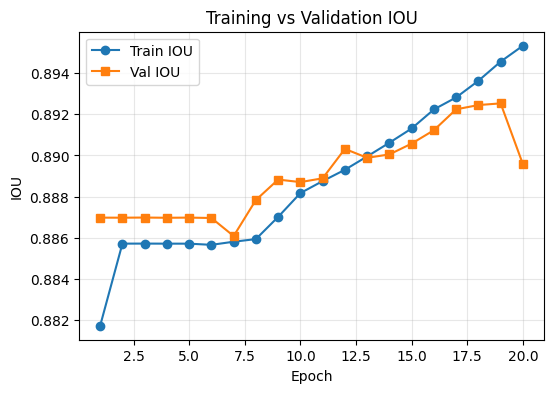

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(epochs, history["train_IOU"], label="Train IOU", marker="o")
plt.plot(epochs, history["val_IOU"],   label="Val IOU",   marker="s")
plt.xlabel("Epoch")
plt.ylabel("IOU")
plt.title("Training vs Validation IOU")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


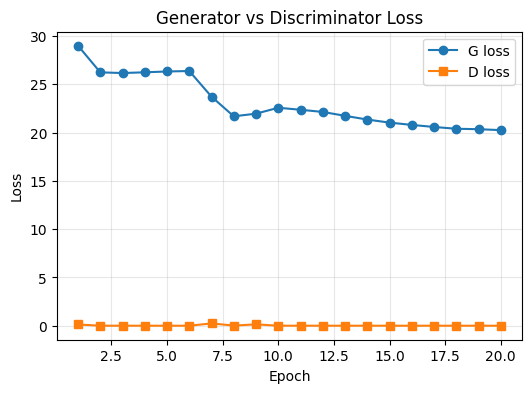

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(epochs, history["train_G"], label="G loss", marker="o")
plt.plot(epochs, history["train_D"], label="D loss", marker="s")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Generator vs Discriminator Loss")
plt.grid(alpha=0.3)
plt.legend()
plt.show()


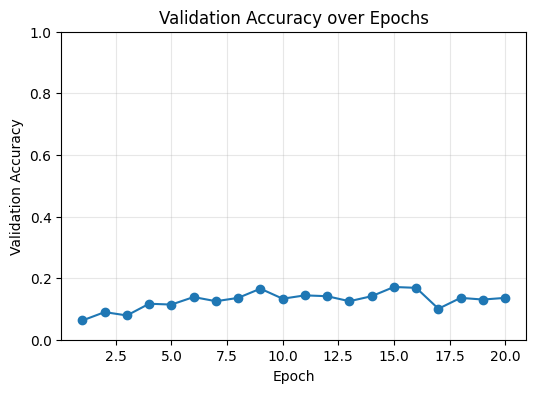

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(epochs, history["val_ACC"], marker="o")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy over Epochs")
plt.ylim(0, 1)
plt.grid(alpha=0.3)
plt.show()


In [ ]:
test_metrics = evaluate_test()
print(f"Test IOU: {test_metrics['IOU']:.3f}")
print(f"Test ACC: {test_metrics['ACC']:.3f}")


Test IOU: 0.884
Test ACC: 0.121


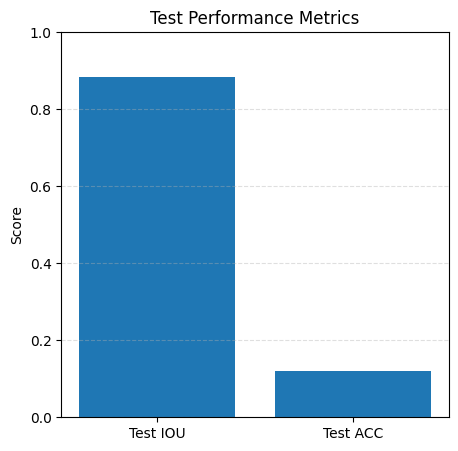

In [ ]:
import matplotlib.pyplot as plt

# values
iou = test_metrics['IOU']
acc = test_metrics['ACC']

plt.figure(figsize=(5,5))
plt.bar(["Test IOU", "Test ACC"], [iou, acc])
plt.ylim(0,1)             # metric range 0–1
plt.title("Test Performance Metrics")
plt.ylabel("Score")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.show()


In [ ]:
import cv2
import numpy as np
from PIL import Image

def make_rgba_from_binary(img_t, bin_mask):

    rgb = (img_t.permute(1,2,0).cpu().numpy() * 255).astype(np.uint8)

    alpha = (bin_mask.astype(np.uint8) * 255)  # 0 or 255

    return Image.fromarray(np.dstack([rgb, alpha]), "RGBA")


In [ ]:
ds = PetsSegCLSDataset(img_size=Cfg.img_size)
print("Dataset length:", len(ds))


Dataset length: 3680


In [ ]:
idx_to_class = {i: name for i, name in enumerate(ds.ds.classes)}

print("Class mapping loaded. Total classes:", len(idx_to_class))

Class mapping loaded. Total classes: 37


In [ ]:
import numpy as np, cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch, random

@torch.no_grad()
def predict_mask_and_label(model, img_t):

    model.eval()
    mlogits, clogits = model(img_t[None].to(DEVICE))
    prob  = torch.sigmoid(mlogits)[0, 0].cpu().numpy()
    label_id = int(clogits.argmax(1).item())
    return prob, label_id


def change_background_with_binary(img_t, bin_mask, bg_path=None, bg_color=(135, 206, 250)):

    fg = (img_t.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

    H, W = bin_mask.shape
    mask3 = np.dstack([bin_mask]*3).astype(np.uint8)   # (H,W,3)

    if bg_path is not None:
        bg = np.array(Image.open(bg_path).convert("RGB"))
        bg = cv2.resize(bg, (W, H))
    else:
        bg = np.full((H, W, 3), bg_color, dtype=np.uint8)

    comp = fg * mask3 + bg * (1 - mask3)
    return comp

In [ ]:
def pred_to_binary(mask_prob, thr=0.45):
    mask = (mask_prob >= thr).astype("uint8")
    kernel = np.ones((5, 5), np.uint8)

    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=3)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  kernel, iterations=2)

    num_labels, labels = cv2.connectedComponents(mask)
    if num_labels > 1:
        areas = [(labels == i).sum() for i in range(1, num_labels)]
        best = 1 + int(np.argmax(areas))
        mask = (labels == best).astype("uint8")
    return mask

def make_rgba(img_t, mask_prob, thr=0.45):
    rgb = (img_t.permute(1,2,0).cpu().numpy() * 255).astype(np.uint8)
    bin_mask = pred_to_binary(mask_prob, thr=thr)
    alpha = bin_mask * 255
    return Image.fromarray(np.dstack([rgb, alpha]), "RGBA")

def change_background_with_pred(img_t, mask_prob, thr=0.45, color=(135, 206, 250)):
    rgb = (img_t.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
    bin_mask = pred_to_binary(mask_prob, thr=thr)

    h, w = bin_mask.shape
    mask3 = np.dstack([bin_mask]*3)
    bg = np.full((h, w, 3), color, dtype=np.uint8)
    out = rgb * mask3 + bg * (1 - mask3)
    return out


In [ ]:
import cv2
import numpy as np

def pred_to_binary(mask_prob, thr=0.45):

    mask = (mask_prob >= thr).astype("uint8")

    kernel = np.ones((5, 5), np.uint8)

    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=3)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN,  kernel, iterations=2)

    num_labels, labels = cv2.connectedComponents(mask)
    if num_labels > 1:
        areas = [(labels == i).sum() for i in range(1, num_labels)]
        best = 1 + int(np.argmax(areas))
        mask = (labels == best).astype("uint8")

    return mask


def change_background_with_pred(img_t, bin_mask, color=(135, 206, 250)):

    rgb = (img_t.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

    h, w = bin_mask.shape
    bin_mask = bin_mask.astype(np.uint8)

    mask3 = np.dstack([bin_mask] * 3)

    bg = np.full((h, w, 3), color, dtype=np.uint8)
    out = rgb * mask3 + bg * (1 - mask3)
    return out


In [ ]:
import numpy as np, cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch, random

@torch.no_grad()
def predict_mask_and_label(model, img_t):
    """
    model  : trained Generator G
    img_t  : single image tensor (C,H,W), 0..1
    return : (mask_prob (H,W), label_id)
    """
    model.eval()
    mlogits, clogits = model(img_t[None].to(DEVICE))
    prob  = torch.sigmoid(mlogits)[0, 0].cpu().numpy()
    label_id = int(clogits.argmax(1).item())
    return prob, label_id


def change_background_with_binary(img_t, bin_mask, bg_path=None, bg_color=(135, 206, 250)):
    """
    img_t    : (C,H,W) tensor, 0..1
    bin_mask : (H,W) numpy 0/1 (1 = pet)
    bg_path  : optional background image path
    bg_color : agar bg image na ho, to solid color (R,G,B)
    """
    fg = (img_t.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)

    H, W = bin_mask.shape
    mask3 = np.dstack([bin_mask]*3).astype(np.uint8)   # (H,W,3)

    if bg_path is not None:
        bg = np.array(Image.open(bg_path).convert("RGB"))
        bg = cv2.resize(bg, (W, H))
    else:
        bg = np.full((H, W, 3), bg_color, dtype=np.uint8)

    comp = fg * mask3 + bg * (1 - mask3)
    return comp

Sample index: 787
Prob min/max: 0.40115106105804443 0.7560002207756042
Predicted class id: 15
Predicted class name: Great Pyrenees


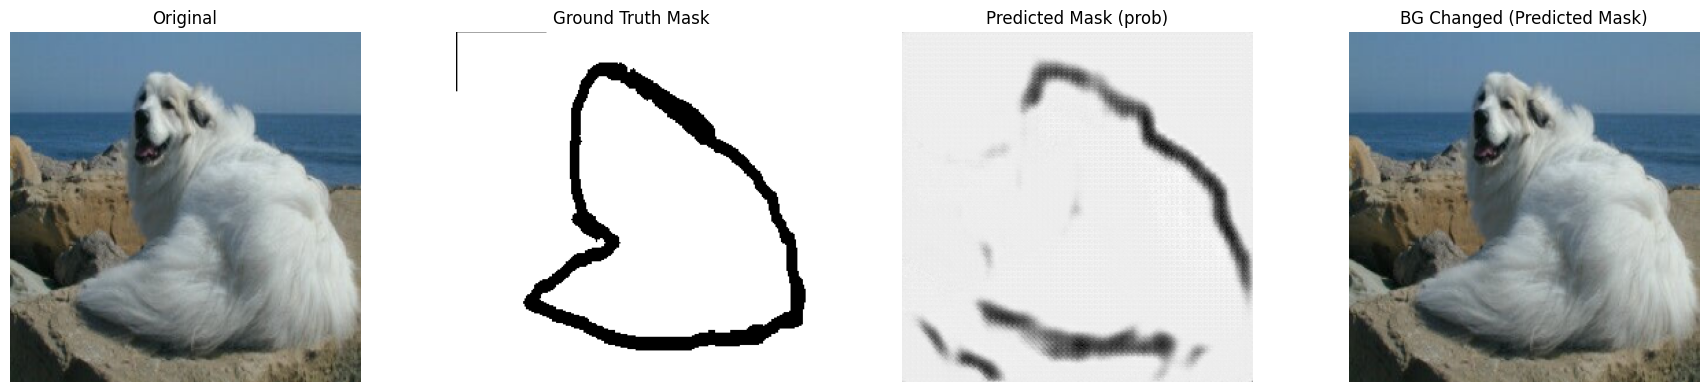

In [ ]:
idx = random.randint(0, len(ds) - 1)
img0, gt_mask_t, y0 = ds[idx]
gt_mask = gt_mask_t[0].cpu().numpy()

prob, pred_id = predict_mask_and_label(G, img0)
pred_name = idx_to_class.get(pred_id, f"id_{pred_id}")

print("Sample index:", idx)
print("Prob min/max:", float(prob.min()), float(prob.max()))
print("Predicted class id:", pred_id)
print("Predicted class name:", pred_name)

pred_bin = pred_to_binary(prob, thr=0.45)

bg_changed = change_background_with_pred(
    img0,
    pred_bin,
    color=(135, 206, 250)
)
fig, axs = plt.subplots(1, 4, figsize=(18, 4))

axs[0].imshow(img0.permute(1,2,0).cpu())
axs[0].set_title("Original")
axs[0].axis("off")

axs[1].imshow(gt_mask, cmap="gray")
axs[1].set_title("Ground Truth Mask")
axs[1].axis("off")

axs[2].imshow(prob, cmap="gray")
axs[2].set_title("Predicted Mask (prob)")
axs[2].axis("off")

axs[3].imshow(bg_changed)
axs[3].set_title("BG Changed (Predicted Mask)")
axs[3].axis("off")

plt.tight_layout()
plt.show()